# Modules import

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-

In [2]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [3]:
!pip install pytorch-crf

In [4]:
from datasets import load_dataset
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

from torchcrf import CRF
from transformers import AutoTokenizer, BertForTokenClassification
from peft import get_peft_model, LoraConfig

import wandb

2025-05-26 09:23:41.453547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748251421.672917      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748251421.744998      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
wandb.login(key='ed1d70d97135ff9f75ecf508641512d002b31926')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vchemsmisl to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [7]:
import warnings
warnings.filterwarnings(action='ignore')

# Data loading and transformation

In [8]:
pd_strat_df = pd.read_excel(
    '/kaggle/input/propaganda-strategies-corpus/propaganda_news_labeled_prepared_corpus.xlsx'
).drop(columns='Unnamed: 0')
pd_strat_df.head(10)

,tokens,tags
0,"['Истек', 'срок', 'действия', 'объявленного', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
1,"['Путин', 'заявил', 'о', 'нарушении', 'Киевом'...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Dysphem..."
2,"['Президент', 'России', 'объявил', 'пасхальное...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,"['Минобороны', 'опубликовало', 'рассекреченные...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,"['Путин', 'отметил', 'вклад', 'ракетно-космиче...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
5,"['Дюмин', 'сообщил', 'о', 'стабильной', 'ситуа...","['O', 'O', 'O', 'O', 'O', 'O', 'B-Loaded_Langu..."
6,"['Путин', 'сообщил', 'о', 'строительстве', '49...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
7,"['Путин', 'указал', 'на', 'приоритетное', 'вни...","['O', 'O', 'O', 'B-Loaded_Language', 'O', 'O',..."
8,"['Путин', 'обсудил', 'с', 'членами', 'Совбеза'...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
9,"['ГД', 'приняла', 'поправки', 'об', 'освобожде...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [9]:
pd_strat_df['tokens'] = pd_strat_df['tokens'].apply(
    lambda x: x.lstrip("\"['").rstrip("']\"").split("', '")
)

pd_strat_df['tags'] = pd_strat_df['tags'].apply(
    lambda x: x.lstrip("\"['").rstrip("']\"").split("', '")
)
pd_strat_df.head(10)

,tokens,tags
0,"[Истек, срок, действия, объявленного, Россией,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[Путин, заявил, о, нарушении, Киевом, моратори...","[O, O, O, O, O, O, O, B-Dysphemism, O, O, B-We..."
2,"[Президент, России, объявил, пасхальное, перем...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[Минобороны, опубликовало, рассекреченные, док...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[Путин, отметил, вклад, ракетно-космической, о...","[O, O, O, O, O, O, O, O, O, O, B-Euphemism, O,..."
5,"[Дюмин, сообщил, о, стабильной, ситуации, и, п...","[O, O, O, O, O, O, B-Loaded_Language, I-Loaded..."
6,"[Путин, сообщил, о, строительстве, 49, корабле...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7,"[Путин, указал, на, приоритетное, внимание, к,...","[O, O, O, B-Loaded_Language, O, O, O, O, O, O,..."
8,"[Путин, обсудил, с, членами, Совбеза, развитие...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
9,"[ГД, приняла, поправки, об, освобождении, от, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


## for binary sequence labeling:

In [ ]:
cast_to_bin_dict = {
    'O': 0, 
    'B-Appeal_to_Authority': 1, 
    'I-Appeal_to_Authority': 1,
    'B-Dysphemism': 1,
    'I-Dysphemism': 1, 
    'B-Euphemism': 1,
    'I-Euphemism': 1,
    'B-Exaggeration': 1,
    'I-Exaggeration': 1, 
    'B-Flag-waving': 1,
    'I-Flag-waving': 1,
    'B-Glittering_Generalities': 1, 
    'I-Glittering_Generalities': 1,
    'B-Loaded_Language': 1, 
    'I-Loaded_Language': 1,
    'B-Minimization': 1, 
    'I-Minimization': 1,
    'B-Name-Calling': 1,
    'I-Name-Calling': 1,
    'B-Slogan': 1, 
    'I-Slogan': 1,
    'B-Thought-terminating_cliché': 1, 
    'I-Thought-terminating_cliché': 1,
    'B-Weasel_Words': 1,
    'I-Weasel_Words': 1,       
}

In [ ]:
pd_strat_df_sl = pd_strat_df.copy()
pd_strat_df_sl['tags'] = pd_strat_df['tags'].apply(lambda x: [cast_to_bin_dict[tag] for tag in x])

pd_strat_df_sl.head(10)

In [ ]:
pd_strat_df_sl_train = pd_strat_df_sl.loc[0:1220]
print(pd_strat_df_sl_train.info())
pd_strat_df_sl_train.head(10)

In [ ]:
pd_strat_df_sl_test = pd_strat_df_sl.loc[1220:]
print(pd_strat_df_sl_test.info())
pd_strat_df_sl_test.head(10)

## for multiclass sequence classification:

In [10]:
cast_to_multi_dict = {
    'O': 0, 
    'B-Appeal_to_Authority': 1, 
    'I-Appeal_to_Authority': 2,
    'B-Dysphemism': 3,
    'I-Dysphemism': 4, 
    'B-Euphemism': 5,
    'I-Euphemism': 6,
    'B-Exaggeration': 7,
    'I-Exaggeration': 8, 
    'B-Flag-waving': 9,
    'I-Flag-waving': 10,
    'B-Glittering_Generalities': 11, 
    'I-Glittering_Generalities': 12,
    'B-Loaded_Language': 13, 
    'I-Loaded_Language': 14,
    'B-Minimization': 15, 
    'I-Minimization': 16,
    'B-Name-Calling': 17,
    'I-Name-Calling': 18,
    'B-Slogan': 19, 
    'I-Slogan': 20,
    'B-Thought-terminating_cliché': 21, 
    'I-Thought-terminating_cliché': 22,
    'B-Weasel_Words': 23,
    'I-Weasel_Words': 24,       
}

In [11]:
pd_strat_df_sc = pd_strat_df.copy()
pd_strat_df_sc['tags'] = pd_strat_df['tags'].apply(lambda x: [cast_to_multi_dict[tag] for tag in x])

pd_strat_df_sc.head(10)

,tokens,tags
0,"[Истек, срок, действия, объявленного, Россией,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[Путин, заявил, о, нарушении, Киевом, моратори...","[0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 23, 24, 24, 0, ..."
2,"[Президент, России, объявил, пасхальное, перем...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[Минобороны, опубликовало, рассекреченные, док...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[Путин, отметил, вклад, ракетно-космической, о...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, ..."
5,"[Дюмин, сообщил, о, стабильной, ситуации, и, п...","[0, 0, 0, 0, 0, 0, 13, 14, 0, 0, 5, 0, 0, 0, 0..."
6,"[Путин, сообщил, о, строительстве, 49, корабле...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,"[Путин, указал, на, приоритетное, внимание, к,...","[0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
8,"[Путин, обсудил, с, членами, Совбеза, развитие...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,"[ГД, приняла, поправки, об, освобождении, от, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [12]:
def find_context(tokens, tags):
    all_contexts = []
    all_tags = []

    for idx, tag in enumerate(tags):
        context = []
        context_tags = []
        if tag in range(1, 24, 2):

            ## for left context
            for i in range(idx, 0, -1):
                try:
                    if '.' in tokens[i] or '!' in tokens[i] or '?' in tokens[i]:
                        context.extend(tokens[i+1:idx])
                        context_tags.extend(tags[i+1:idx])
                        break
                except IndexError:
                    context.extend(tokens[i+1:idx])
                    context_tags.extend(tags[i+1:idx])
                    break
                if not context:
                    context.extend(tokens[i+1:idx])
                    context_tags.extend(tags[i+1:idx])

            ## for right context
            for i in range(idx, len(tokens)):
                try:
                    if '.' in tokens[i] or '!' in tokens[i] or '?' in tokens[i]:
                        context.extend(tokens[idx:i])
                        context_tags.extend(tags[idx:i])
                        break
                except IndexError:
                    context.extend(tokens[idx:i])
                    context_tags.extend(tags[idx:i])
                    break
                if not context:
                    context.extend(tokens[idx:i])
                    context_tags.extend(tags[idx:i])

            if context and context_tags:
                all_contexts.append(context)
                all_tags.append(context_tags)
            else:
                all_contexts.append(None)
                all_tags.append(None)

    return all_contexts, all_tags

In [13]:
contexts = []
context_tags = []

for i, row in pd_strat_df_sc.iterrows():
    row_context, row_tags = find_context(row['tokens'], row['tags'])

    contexts.extend(row_context)
    context_tags.extend(row_tags)

pd_strat_df_sc_contexts = pd.DataFrame(
    {
        'tokens': contexts,
        'tags': context_tags
    }
)

In [14]:
pd_strat_df_sc_contexts.head(10)

,tokens,tags
0,"[принято, Решение, главы, государства, о, пасх...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 12, 12, 0, 0, ..."
1,"[и, При, этом, он, подчеркнул, ,, что, российс...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[украинских, При, этом, он, подчеркнул, ,, что...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[на, удары, по, энергообъектам, более, 100, ра...","[0, 3, 0, 0, 23, 24, 24, 0, 0, 0, 0, 0, 0, 23,..."
4,"[энергообъектам, более, 100, раз, Вооруженные,...","[0, 23, 24, 24, 0, 0, 0, 0, 0, 0, 23, 24, 24, ..."
5,"[), более, ста, раз, нарушали, мораторий, на, ...","[0, 23, 24, 24, 0, 0, 0, 3, 0, 0, 0]"
6,"[на, удары, по, энергетическим, объектам]","[0, 3, 0, 0, 0]"
7,"[«Киевский, режим, более, ста, раз, ,, как, вы...","[0, 3, 23, 24, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,"[режим, «Киевский, режим, более, ста, раз, ,, ...","[3, 0, 3, 23, 24, 24, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,"[ненанесении, «Киевский, режим, более, ста, ра...","[0, 0, 3, 23, 24, 24, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
pd_strat_df_sc_train = pd_strat_df_sc_contexts.loc[0:11713].dropna()
print(pd_strat_df_sc_train.info())
pd_strat_df_sc_train.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 11105 entries, 0 to 11713
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tokens  11105 non-null  object
 1   tags    11105 non-null  object
dtypes: object(2)
memory usage: 260.3+ KB
None


,tokens,tags
0,"[принято, Решение, главы, государства, о, пасх...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 12, 12, 0, 0, ..."
1,"[и, При, этом, он, подчеркнул, ,, что, российс...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[украинских, При, этом, он, подчеркнул, ,, что...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[на, удары, по, энергообъектам, более, 100, ра...","[0, 3, 0, 0, 23, 24, 24, 0, 0, 0, 0, 0, 0, 23,..."
4,"[энергообъектам, более, 100, раз, Вооруженные,...","[0, 23, 24, 24, 0, 0, 0, 0, 0, 0, 23, 24, 24, ..."
5,"[), более, ста, раз, нарушали, мораторий, на, ...","[0, 23, 24, 24, 0, 0, 0, 3, 0, 0, 0]"
6,"[на, удары, по, энергетическим, объектам]","[0, 3, 0, 0, 0]"
7,"[«Киевский, режим, более, ста, раз, ,, как, вы...","[0, 3, 23, 24, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,"[режим, «Киевский, режим, более, ста, раз, ,, ...","[3, 0, 3, 23, 24, 24, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,"[ненанесении, «Киевский, режим, более, ста, ра...","[0, 0, 3, 23, 24, 24, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
pd_strat_df_sc_test = pd_strat_df_sc_contexts.loc[11713:].dropna()
print(pd_strat_df_sc_test.info())
pd_strat_df_sc_test.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 2625 entries, 11713 to 14451
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tokens  2625 non-null   object
 1   tags    2625 non-null   object
dtypes: object(2)
memory usage: 61.5+ KB
None


,tokens,tags
11713,"[где, Напомним, ,, что, Уиткофф, прилетал, 11,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 24, 2..."
11714,"[урегулирование, Темой, разговора, было, урегу...","[0, 0, 0, 0, 0, 5, 0, 0]"
11715,"[Особое, Особое, внимание, лидеры, уделят, акт...","[7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11716,"[Ушаков, Ушаков, :, Трамп, понимает, первоприч...","[1, 1, 2, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11717,"[первопричины, конфликта, на, Украине, Помощни...","[0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11718,"[возникновения, конфликта, на]","[0, 5, 0]"
11719,"[Он, Он, также, пояснил, ,, какие, есть, препя...","[1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
11720,"[Зарубиным, В, беседе, с, корреспондентом, тел...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, ..."
11722,"[Однако, многолетний, негативный, настрой, в, ...","[0, 23, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
11723,"[многолетний, Однако, многолетний, негативный,...","[23, 0, 23, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


In [17]:
pd_strat_df_sc_contexts['tokens'].dropna().apply(len).describe()

count    13729.000000
mean        23.583801
std         11.638832
min          1.000000
25%         16.000000
50%         22.000000
75%         30.000000
max         93.000000
Name: tokens, dtype: float64

# 1 Binary sequence labeling

## Data preparation:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

In [ ]:
def tokenize_sample(
    sample: pd.Series, tokenizer: AutoTokenizer, max_length: int
) -> dict[str, torch.Tensor]:
    
    tokens = tokenizer(text=sample['tokens'],
                       max_length=max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt',
                      is_split_into_words=True)

    word_ids = tokens.word_ids()  
    previous_word_idx = None
    labels = []
    labels_crf = []
    
    for word_idx in word_ids: 
        if word_idx is None:
            labels.append(-100)
            labels_crf.append(0)
        elif word_idx != previous_word_idx:  
            labels.append(sample['tags'][word_idx])
            labels_crf.append(sample['tags'][word_idx])
        else:
            labels.append(-100)
            labels_crf.append(0)
            
        previous_word_idx = word_idx

    tokens_dict = {
                "input_ids": tokens.data["input_ids"][0],
                "attention_mask": tokens.data["attention_mask"][0],
                "labels": torch.tensor(labels),
                "labels_crf": torch.tensor(labels_crf)
            }

    assert tokens_dict['input_ids'].shape[0] == tokens_dict['labels'].shape[0]
    assert tokens_dict['input_ids'].shape[0] == tokens_dict['labels_crf'].shape[0]

    return tokens_dict

In [ ]:
class TrainDataset(Dataset):

    def __init__(self, data, tokenizer, max_length) -> None:
        self._data = data.apply(
            lambda sample: tokenize_sample(sample, tokenizer, max_length),
            axis=1
        )
        self._data.reset_index(drop=True, inplace=True)

    def __len__(self) -> int:
        return len(self._data)

    def __getitem__(self, index: int) -> dict[str, torch.Tensor]:
        return self._data.loc[index]

In [ ]:
MAX_LENGTH = 300

In [ ]:
pd_strat_df_sl_train_dset = TrainDataset(pd_strat_df_sl_train, tokenizer, MAX_LENGTH)
pd_strat_df_sl_test_dset = TrainDataset(pd_strat_df_sl_test, tokenizer, MAX_LENGTH)

In [ ]:
pd_strat_df_sl_train_dload = DataLoader(pd_strat_df_sl_train_dset, batch_size=16, shuffle=True)
pd_strat_df_sl_test_dload = DataLoader(pd_strat_df_sl_test_dset, batch_size=16, shuffle=False)

## Train

### Models & Training module

In [ ]:
# 1. Only CRF training
class SL_BERTCRF_CRFOnly(nn.Module):

    def __init__(self, output_dim):
        super().__init__()

        self.bert = BertForTokenClassification.from_pretrained('DeepPavlov/rubert-base-cased')
        self.bert.eval()
        self.sigmoid = nn.Sigmoid()
            
        self.crf = CRF(num_tags=output_dim, batch_first=True)


    def forward(self, sample):

        with torch.no_grad():
            bert_output = self.bert(sample['input_ids'], 
                                        attention_mask=sample['attention_mask']).logits
        emission_probas = self.sigmoid(bert_output)

        self.crf(emission_probas, sample['labels_crf'].to(DEVICE), reduction='mean')
  
        output = self.crf.decode(emission_probas)
        return output, bert_output[:, :, -1]

In [ ]:
# 2. CRF + BERT Head training
class SL_BERTCRF_HeadOnly(nn.Module):

    def __init__(self, output_dim):
        super().__init__()

        self.bert = BertForTokenClassification.from_pretrained('DeepPavlov/rubert-base-cased')
        for param in self.bert.base_model.parameters(): 
            param.requires_grad = False
        self.bert.train()
        self.sigmoid = nn.Sigmoid()
            
        self.crf = CRF(num_tags=output_dim, batch_first=True)

    def forward(self, sample):
        
        bert_output = self.bert(sample['input_ids'].to(DEVICE), 
                                    attention_mask=sample['attention_mask'].to(DEVICE)).logits
        emission_probas = self.sigmoid(bert_output)

        self.crf(emission_probas, sample['labels_crf'].to(DEVICE), reduction='mean')
  
        output = self.crf.decode(emission_probas)
        return output, bert_output[:, :, -1]

In [ ]:
# 3. BERT Head only
class SL_BERT_HeadOnly(nn.Module):

    def __init__(self, output_dim):
        super().__init__()

        self.bert = BertForTokenClassification.from_pretrained('DeepPavlov/rubert-base-cased')
        for param in self.bert.base_model.parameters(): 
            param.requires_grad = False
        self.bert.train()
        self.sigmoid = nn.Sigmoid()

    def forward(self, sample):
        
        bert_output = self.bert(sample['input_ids'], 
                                    attention_mask=sample['attention_mask']).logits
        emission_probas = self.sigmoid(bert_output)
        return None, emission_probas[:, :, -1]

In [ ]:
class SL_BERTCRF_TrainingModule(pl.LightningModule):
    def __init__(self, model, learning_rate, add_scheduler=False, bert_only=False):
        super().__init__()

        self.model = model
        self.learning_rate = learning_rate
        self.add_scheduler = add_scheduler
        self.bert_only = bert_only

    def forward(self, X):
        return self.model(X)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        if not self.add_scheduler:
            return optimizer

        else:
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)
            return ([optimizer], [scheduler])

    def training_step(self, train_batch):

        pred_crf, pred_bert = self.model(train_batch)

        pred_bert = pred_bert.view(train_batch['labels'].shape)
        bert_train_loss = F.binary_cross_entropy_with_logits(
            pred_bert.to(DEVICE),
            train_batch['labels_crf'].to(torch.float).to(DEVICE)
        )

        if not self.bert_only:
            pred_crf = torch.tensor(pred_crf, dtype=torch.float, requires_grad=True)
            crf_train_loss = F.binary_cross_entropy_with_logits(
                pred_crf.to(DEVICE),
                train_batch['labels_crf'].to(torch.float).to(DEVICE) # labels_crf потому что бинарная КЭ
            )
            train_loss = (crf_train_loss + bert_train_loss) / 2
        else:
            train_loss = bert_train_loss

        self.log("train_loss", train_loss, prog_bar=True)
        return train_loss

    def validation_step(self, val_batch):

        pred_crf, pred_bert = self.model(val_batch)

        
        bert_val_loss = F.binary_cross_entropy_with_logits(
            pred_bert.to(DEVICE),
            val_batch['labels_crf'].to(torch.float).to(DEVICE)
        )

        if not self.bert_only:
            pred_crf = torch.tensor(pred_crf, dtype=torch.float, requires_grad=True)
            crf_val_loss = F.binary_cross_entropy_with_logits(
                pred_crf.to(DEVICE),
                val_batch['labels_crf'].to(torch.float).to(DEVICE)
            )
            val_loss = (crf_val_loss + bert_val_loss) / 2
            pred = pred_crf
        else:
            val_loss = bert_val_loss
            pred = torch.sigmoid(pred_bert).round()

        f1 = f1_score(
            val_batch['labels_crf'].cpu().numpy(),
            pred.cpu().numpy(),
            average='samples'
        )

        self.log("val_loss", val_loss, prog_bar=True)
        self.log('val_f1', f1, prog_bar=True)
        return val_loss

### Training

In [ ]:
def seed_everything(seed):

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
# 1. Only CRF training

EPOCHS = 3
LR = 1e-3

wandb_logger = WandbLogger(log_model='all', project='PDBT_SL - Only CRF')
sl_crfonly_model = SL_BERTCRF_CRFOnly(output_dim=2)

train_module = SL_BERTCRF_TrainingModule(sl_crfonly_model, LR)
seed_everything(42)
trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, pd_strat_df_sl_train_dload, pd_strat_df_sl_test_dload)

In [ ]:
wandb.finish()

In [ ]:
# 2. BERT Head + CRF training

EPOCHS = 25
LR = 1e-3

wandb_logger = WandbLogger(log_model='all', project='PDBT_SL - HeadOnly')
sl_head_model = SL_BERTCRF_HeadOnly(output_dim=2)

train_module = SL_BERTCRF_TrainingModule(sl_head_model, LR)
seed_everything(42)
trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, pd_strat_df_sl_train_dload, pd_strat_df_sl_test_dload)

In [ ]:
wandb.finish()

In [ ]:
# 3. BERT Head only training

EPOCHS = 3
LR = 1e-3

wandb_logger = WandbLogger(log_model='all', project='PDBT_SL - BERT Head only')
sl_head_bert_model = SL_BERT_HeadOnly(output_dim=2)

train_module = SL_BERTCRF_TrainingModule(sl_head_bert_model, LR, bert_only=True)
seed_everything(42)
trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, pd_strat_df_sl_train_dload, pd_strat_df_sl_test_dload)

In [ ]:
wandb.finish()

### Best SL model inference

In [ ]:
best_model = SL_BERTCRF_HeadOnly(output_dim=2)
best_model.load_state_dict(
            torch.load('/kaggle/input/bert_crf_binary_sequence_labeling_pretrained/pytorch/default/1/sl_head_model.pt', 
                       weights_only=True))
best_model = best_model.to(DEVICE)
best_model.eval()

In [ ]:
test_dl = DataLoader(pd_strat_df_sl_test_dset, 
                     batch_size=len(pd_strat_df_sl_test_dset), 
                     shuffle=False)

test = next(iter(test_dl))
with torch.no_grad():
    prediction, _ = best_model(test) 

In [ ]:
f1_wei = f1_score(
    test['labels_crf'].cpu().numpy(),
    np.array(prediction),
    average='weighted'
    )

f1 = f1_score(
    test['labels_crf'].cpu().numpy(),
    np.array(prediction),
    average='samples'
    )

print(f1_wei)
print(f1)

### Saving best model

In [ ]:
torch.save(sl_head_model.state_dict(), '/kaggle/working/sl_head_model.pt') 

# 2 Multiclass sequence classification

## Data preparation:

In [18]:
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [19]:
def tokenize_sample(
    sample: pd.Series, tokenizer: AutoTokenizer, max_length: int
) -> dict[str, torch.Tensor]:
    
    tokens = tokenizer(text=sample['tokens'],
                       max_length=max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt',
                      is_split_into_words=True)

    word_ids = tokens.word_ids()  
    previous_word_idx = None
    labels = []
    labels_crf = []
    
    for word_idx in word_ids: 
        if word_idx is None:
            labels.append(-100)
            labels_crf.append(0)
        elif word_idx != previous_word_idx:  
            labels.append(sample['tags'][word_idx])
            labels_crf.append(sample['tags'][word_idx])
        else:
            labels.append(-100)
            labels_crf.append(0)
            
        previous_word_idx = word_idx

    tokens_dict = {
                "input_ids": tokens.data["input_ids"][0],
                "attention_mask": tokens.data["attention_mask"][0],
                "labels": torch.tensor(labels),
                "labels_crf": torch.tensor(labels_crf)
            }

    assert tokens_dict['input_ids'].shape[0] == tokens_dict['labels'].shape[0]
    assert tokens_dict['input_ids'].shape[0] == tokens_dict['labels_crf'].shape[0]

    return tokens_dict

In [20]:
class TrainDataset(Dataset):

    def __init__(self, data, tokenizer, max_length) -> None:
        self._data = data.apply(
            lambda sample: tokenize_sample(sample, tokenizer, max_length),
            axis=1
        )
        self._data.reset_index(drop=True, inplace=True)

    def __len__(self) -> int:
        return len(self._data)

    def __getitem__(self, index: int) -> dict[str, torch.Tensor]:
        return self._data.loc[index]

In [21]:
MAX_LENGTH = 40

In [22]:
pd_strat_df_sc_train_dset = TrainDataset(pd_strat_df_sc_train, tokenizer, MAX_LENGTH)
pd_strat_df_sc_test_dset = TrainDataset(pd_strat_df_sc_test, tokenizer, MAX_LENGTH)

In [23]:
pd_strat_df_sc_train_dload = DataLoader(pd_strat_df_sc_train_dset, batch_size=32, shuffle=True)
pd_strat_df_sc_test_dload = DataLoader(pd_strat_df_sc_test_dset, batch_size=32, shuffle=False)

## Train

### Models & Training module

In [ ]:
# 1. model to load pretraned
class SL_BERTCRF_HeadOnly(nn.Module):

    def __init__(self, output_dim):
        super().__init__()

        self.bert = BertForTokenClassification.from_pretrained('DeepPavlov/rubert-base-cased')
        for param in self.bert.base_model.parameters(): 
            param.requires_grad = False
        self.bert.train()
        self.sigmoid = nn.Sigmoid()
            
        self.crf = CRF(num_tags=output_dim, batch_first=True)

    def forward(self, sample):
        
        bert_output = self.bert(sample['input_ids'], 
                                    attention_mask=sample['attention_mask']).logits
        emission_probas = self.sigmoid(bert_output)

        self.crf(emission_probas, sample['labels_crf'].to(DEVICE), reduction='mean')
  
        output = self.crf.decode(emission_probas)
        return output, bert_output[:, :, -1]

In [ ]:
# 1. Pre-trained BERTCRF on previous task (using the same class)
class SC_BERTCRF(nn.Module):

    def __init__(self, output_dim):
        super().__init__()

        self.model = SL_BERTCRF_HeadOnly(output_dim=2)
        self.model.load_state_dict(
            torch.load('/kaggle/input/bert_crf_binary_sequence_labeling_pretrained/pytorch/default/1/sl_head_model.pt', 
                       weights_only=True))
        self.model.eval()

        self.head = nn.Linear(2, output_dim)

    def forward(self, sample):
        bert_output = self.model.bert(sample['input_ids'], 
                                    attention_mask=sample['attention_mask']).logits
        emission_probas = self.model.sigmoid(bert_output)
        output = self.head(emission_probas) 
       
        return output

In [ ]:
# 2. BERT Head only
class SC_BERT_HeadOnly(nn.Module):

    def __init__(self, output_dim):
        super().__init__()

        self.bert = BertForTokenClassification.from_pretrained('DeepPavlov/rubert-base-cased')
        for param in self.bert.base_model.parameters(): 
            param.requires_grad = False
        self.bert.classifier = nn.Linear(768, output_dim)
        self.bert.train()
        self.sigmoid = nn.Sigmoid()

    def forward(self, sample):
        
        bert_output = self.bert(sample['input_ids'], 
                                    attention_mask=sample['attention_mask']).logits
        emission_probas = self.sigmoid(bert_output)
        
        return emission_probas

In [ ]:
class SC_BERT_TrainingModule(pl.LightningModule):
    def __init__(self, model, learning_rate, add_scheduler=False):
        super().__init__()

        self.model = model
        self.learning_rate = learning_rate
        self.add_scheduler = add_scheduler

    def forward(self, X):
        return self.model(X)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        if not self.add_scheduler:
            return optimizer

        else:
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)
            return ([optimizer], [scheduler])

    def training_step(self, train_batch):

        pred = self.model(train_batch)

        pred = pred.view(-1, pred.shape[-1]).to(DEVICE)
        target = train_batch['labels'].view(-1).to(torch.long).to(DEVICE)

        train_loss = F.cross_entropy(pred, target)

        self.log("train_loss", train_loss, prog_bar=True)
        return train_loss

    def validation_step(self, val_batch):

        pred = self.model(val_batch)

        pred = pred.view(-1, pred.shape[-1]).to(DEVICE)
        target = val_batch['labels'].view(-1).to(torch.long).to(DEVICE)
        
        val_loss = F.cross_entropy(pred, target)

        target_numpy = val_batch['labels_crf'].view(-1).cpu().numpy()
        pred_numpy = pred.argmax(dim=1).cpu().numpy()

        mask_target = np.isin(target_numpy, [0], invert=True)
        pred_numpy = pred_numpy[mask_target]
        target_numpy = target_numpy[mask_target]
        
        f1_wei = f1_score(
            target_numpy,
            pred_numpy,
            average='weighted'
        )

        f1_ma = f1_score(
            target_numpy,
            pred_numpy,
            average='micro'
        )

        self.log("val_loss", val_loss, prog_bar=True)
        self.log('val_f1_weighted', f1_wei, prog_bar=True)
        self.log('val_f1_micro-averaged', f1_ma, prog_bar=True)
        return val_loss

### Training

In [ ]:
# 1. Pre-trained BERTCRF on previous task (using the same class)

EPOCHS = 25
LR = 1e-3

wandb_logger = WandbLogger(log_model='all', project='PDBT_SC - pretraied BERTCRF')
sc_bert_crf_model = SC_BERTCRF(output_dim=25)

train_module = SC_BERT_TrainingModule(sc_bert_crf_model, LR)
seed_everything(42)
trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, pd_strat_df_sc_train_dload, pd_strat_df_sc_test_dload)

In [ ]:
wandb.finish()

In [ ]:
# 2. BERT Head only

EPOCHS = 15
LR = 1e-3

wandb_logger = WandbLogger(log_model='all', project='PDBT_SC - BERT Head only')
sc_bert_head_model = SC_BERT_HeadOnly(output_dim=25)

train_module = SC_BERT_TrainingModule(sc_bert_head_model, LR)
seed_everything(42)
trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, pd_strat_df_sc_train_dload, pd_strat_df_sc_test_dload)

In [ ]:
wandb.finish()

### Improving best approach

In [24]:
def seed_everything(seed):

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [25]:
class SL_BERTCRF_HeadOnly(nn.Module):

    def __init__(self, output_dim):
        super().__init__()

        self.bert = BertForTokenClassification.from_pretrained('DeepPavlov/rubert-base-cased')
        for param in self.bert.base_model.parameters(): 
            param.requires_grad = False
        self.bert.train()
        self.sigmoid = nn.Sigmoid()
            
        self.crf = CRF(num_tags=output_dim, batch_first=True)

    def forward(self, sample):
        
        bert_output = self.bert(sample['input_ids'], 
                                    attention_mask=sample['attention_mask']).logits
        emission_probas = self.sigmoid(bert_output)

        self.crf(emission_probas, sample['labels_crf'].to(DEVICE), reduction='mean')
  
        output = self.crf.decode(emission_probas)
        return output, bert_output[:, :, -1]

In [26]:
class SC_BestModel(nn.Module):

    def __init__(self, output_dim, hidden_size):
        super().__init__()

        self.model = SL_BERTCRF_HeadOnly(output_dim=2)
        self.model.load_state_dict(
            torch.load('/kaggle/input/bert_crf_binary_sequence_labeling_pretrained/pytorch/default/1/sl_head_model.pt', 
                       weights_only=True))
        self.model.eval()

        self.head = nn.Sequential(
            nn.Linear(2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_dim)
        )

    def forward(self, sample):
        bert_output = self.model.bert(sample['input_ids'], 
                                    attention_mask=sample['attention_mask']).logits
        emission_probas = self.model.sigmoid(bert_output)
        output = self.head(emission_probas) 
       
        return output

In [27]:
class SC_BestModel_TrainingModule(pl.LightningModule):
    def __init__(self, model, learning_rate, add_scheduler=False):
        super().__init__()

        self.model = model
        self.learning_rate = learning_rate
        self.add_scheduler = add_scheduler

    def forward(self, X):
        return self.model(X)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        if not self.add_scheduler:
            return optimizer

        else:
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)
            return ([optimizer], [scheduler])

    def training_step(self, train_batch):

        pred = self.model(train_batch)

        pred = pred.view(-1, pred.shape[-1]).to(DEVICE)
        target = train_batch['labels'].view(-1).to(torch.long).to(DEVICE)

        train_loss = F.cross_entropy(pred, target)

        self.log("train_loss", train_loss, prog_bar=True)
        return train_loss

    def validation_step(self, val_batch):

        pred = self.model(val_batch)

        pred = pred.view(-1, pred.shape[-1]).to(DEVICE)
        target = val_batch['labels'].view(-1).to(torch.long).to(DEVICE)
        
        val_loss = F.cross_entropy(pred, target)

        target_numpy = val_batch['labels_crf'].view(-1).cpu().numpy()
        pred_numpy = pred.argmax(dim=1).cpu().numpy()

        mask_target = np.isin(target_numpy, [0], invert=True)
        pred_numpy = pred_numpy[mask_target]
        target_numpy = target_numpy[mask_target]
        
        f1_wei = f1_score(
            target_numpy,
            pred_numpy,
            average='weighted'
        )

        f1_ma = f1_score(
            target_numpy,
            pred_numpy,
            average='micro'
        )

        self.log("val_loss", val_loss, prog_bar=True)
        self.log('val_f1_weighted', f1_wei, prog_bar=True)
        self.log('val_f1_micro-averaged', f1_ma, prog_bar=True)
        return val_loss

In [28]:
EPOCHS = 18
LR = 1e-3
HIDDEN = 256

wandb_logger = WandbLogger(log_model='all', project='PDBT_SC - Best model')
best_model = SC_BestModel(output_dim=25, hidden_size=HIDDEN)

train_module = SC_BestModel_TrainingModule(best_model, LR)
seed_everything(42)
trainer = pl.Trainer(logger=wandb_logger, accelerator="gpu", max_epochs=EPOCHS)
trainer.fit(train_module, pd_strat_df_sc_train_dload, pd_strat_df_sc_test_dload)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [29]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
train_loss,█▇▂▄▆▄▄▄▃▃▄▄▂▃▃▅▃▂▄▃▂▁▅▅▁▄▃▃▂▃▄▃▅▂▄▄▁▂▄▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
val_f1_micro-averaged,▁▅▅▄▆▅▆▅▅▄▄▆▇▆▇▇▆█
val_f1_weighted,▁▅▆▅▆▆▆▆▆▅▅▆▇▆▇▇▇█
val_loss,█▄▃▄▃▃▂▂▃▃▃▂▂▂▁▂▁▁
epoch,17
train_loss,0.59613
trainer/global_step,6263
val_f1_micro-averaged,0.48652
val_f1_weighted,0.55396


## Best SC model inference

In [30]:
def to_strategy_class(tags):
    new_tags = []
    for tag in tags:
        if tag % 2 == 1:
            new_tags.append(tag + 1)
        else:
            new_tags.append(tag)
    return np.array(new_tags)

In [31]:
test_dl = DataLoader(pd_strat_df_sc_test_dset, 
                     batch_size=len(pd_strat_df_sc_test_dset), 
                     shuffle=False)

test = next(iter(test_dl))
best_model.eval()
with torch.no_grad():
    prediction = best_model(test)

In [32]:
target_numpy = test['labels_crf'].view(-1).cpu().numpy()
pred_numpy = prediction.view(-1, prediction.shape[-1]).argmax(dim=1).cpu().numpy()

mask_target = np.isin(target_numpy, [0], invert=True)
masked_pred_numpy = pred_numpy[mask_target]
masked_target_numpy = target_numpy[mask_target]

f1_wei = f1_score(
    masked_target_numpy,
    masked_pred_numpy,
    average='weighted'
    )

f1_ma = f1_score(
    masked_target_numpy,
    masked_pred_numpy,
    average='micro'
    )

print(classification_report(
    masked_target_numpy, masked_pred_numpy,
    target_names=list(cast_to_multi_dict.keys())[1:],
    labels=list(range(1, 25))
)
     )

                              precision    recall  f1-score   support

       B-Appeal_to_Authority       0.84      0.68      0.75      1795
       I-Appeal_to_Authority       0.95      0.71      0.81      5705
                B-Dysphemism       0.67      0.33      0.44      1799
                I-Dysphemism       0.00      0.00      0.00        73
                 B-Euphemism       0.58      0.68      0.63       437
                 I-Euphemism       0.00      0.00      0.00        92
              B-Exaggeration       0.79      0.23      0.35      1105
              I-Exaggeration       0.00      0.00      0.00       229
               B-Flag-waving       0.00      0.00      0.00        82
               I-Flag-waving       0.00      0.00      0.00        23
   B-Glittering_Generalities       0.00      0.00      0.00       283
   I-Glittering_Generalities       0.00      0.00      0.00       105
           B-Loaded_Language       0.00      0.00      0.00       206
           I-Loaded

In [33]:
target_numpy = test['labels_crf'].view(-1).cpu().numpy()
pred_numpy = prediction.view(-1, prediction.shape[-1]).argmax(dim=1).cpu().numpy()

pred_numpy = np.apply_along_axis(to_strategy_class, axis=0, arr=pred_numpy)
target_numpy = np.apply_along_axis(to_strategy_class, axis=0, arr=target_numpy)

mask_target = np.isin(target_numpy, [0], invert=True)
masked_pred_numpy = pred_numpy[mask_target]
masked_target_numpy = target_numpy[mask_target]


f1_wei = f1_score(
    masked_target_numpy,
    masked_pred_numpy,
    average='weighted'
    )

f1_ma = f1_score(
    masked_target_numpy,
    masked_pred_numpy,
    average='micro'
    )

print(classification_report(
    masked_target_numpy, masked_pred_numpy,
    target_names=[
        'Appeal_to_Authority', 'Dysphemism', 'Euphemism', 'Exaggeration',
        'Flag-waving', 'Glittering_Generalities', 'Loaded_Language', 'Minimization',
        'Name-Calling', 'Slogan', 'Thought-terminating_cliché', 'Weasel_Words'
    ],
    labels=list(range(2, 25, 2))
)
     )

                            precision    recall  f1-score   support

       Appeal_to_Authority       0.99      0.76      0.86      7500
                Dysphemism       0.67      0.32      0.43      1872
                 Euphemism       0.67      0.64      0.65       529
              Exaggeration       0.83      0.20      0.32      1334
               Flag-waving       0.00      0.00      0.00       105
   Glittering_Generalities       0.00      0.00      0.00       388
           Loaded_Language       0.00      0.00      0.00       206
              Minimization       0.00      0.00      0.00        24
              Name-Calling       0.00      0.00      0.00       133
                    Slogan       0.00      0.00      0.00        35
Thought-terminating_cliché       0.00      0.00      0.00       104
              Weasel_Words       0.00      0.00      0.00       871

                 micro avg       0.92      0.52      0.67     13101
                 macro avg       0.26      0.1

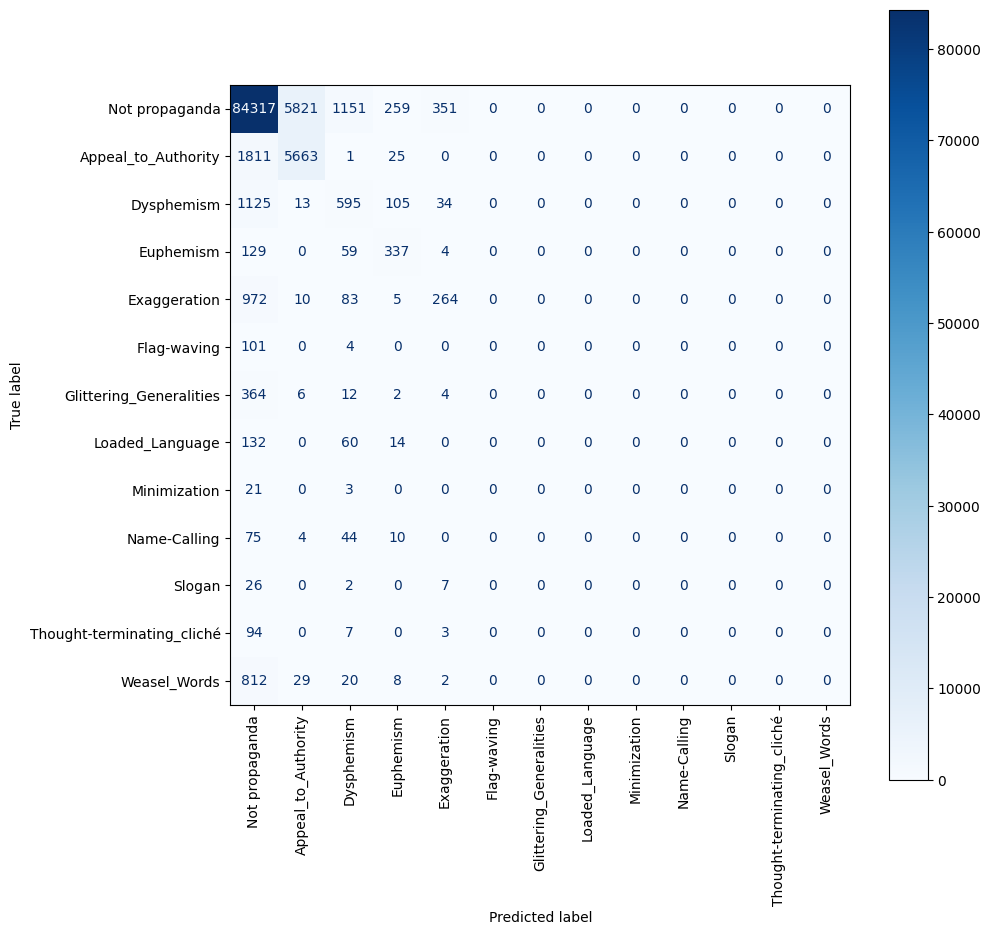

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_predictions(
    target_numpy, pred_numpy,
    display_labels=[
        'Not propaganda',
        'Appeal_to_Authority', 'Dysphemism', 'Euphemism', 'Exaggeration',
        'Flag-waving', 'Glittering_Generalities', 'Loaded_Language', 'Minimization',
        'Name-Calling', 'Slogan', 'Thought-terminating_cliché', 'Weasel_Words'
    ],
    xticks_rotation='vertical',
    cmap=plt.cm.Blues,
    ax=ax
)


In [36]:
pd_strat_df_sc_test

,tokens,tags
11713,"[где, Напомним, ,, что, Уиткофф, прилетал, 11,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23, 24, 2..."
11714,"[урегулирование, Темой, разговора, было, урегу...","[0, 0, 0, 0, 0, 5, 0, 0]"
11715,"[Особое, Особое, внимание, лидеры, уделят, акт...","[7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11716,"[Ушаков, Ушаков, :, Трамп, понимает, первоприч...","[1, 1, 2, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11717,"[первопричины, конфликта, на, Украине, Помощни...","[0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
14447,"[Свет, Старый, Свет, ,, добавил, Пушков, ,, пы...","[0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14448,"[урегулированию, Старый, Свет, ,, добавил, Пуш...","[0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14449,"[деле, Старый, Свет, ,, добавил, Пушков, ,, пы...","[0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14450,"[срывает, Старый, Свет, ,, добавил, Пушков, ,,...","[3, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [41]:
pd_strat_df_sc_test['tags'] = test['labels_crf'].cpu().numpy().tolist()
pd_strat_df_sc_test['predictions'] = prediction.argmax(dim=2).cpu().numpy().tolist()

pd_strat_df_sc_test['tags'] = pd_strat_df_sc_test.apply(
    lambda x: x['tags'][1:len(x['tokens'])+1], axis=1
)
pd_strat_df_sc_test['predictions'] = pd_strat_df_sc_test.apply(
    lambda x: x['predictions'][1:len(x['tokens'])+1], axis=1
)

pd_strat_df_sc_test.head(10)

,tokens,tags,predictions
11713,"[где, Напомним, ,, что, Уиткофф, прилетал, 11,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11714,"[урегулирование, Темой, разговора, было, урегу...","[0, 0, 0, 0, 0, 0, 5, 0]","[0, 0, 0, 0, 0, 0, 0, 0]"
11715,"[Особое, Особое, внимание, лидеры, уделят, акт...","[7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11716,"[Ушаков, Ушаков, :, Трамп, понимает, первоприч...","[1, 1, 2, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, ...","[2, 2, 2, 0, 0, 0, 0, 0, 5, 0, 0, 2, 2, 2, 2, ..."
11717,"[первопричины, конфликта, на, Украине, Помощни...","[0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 5, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
11718,"[возникновения, конфликта, на]","[0, 5, 0]","[0, 5, 0]"
11719,"[Он, Он, также, пояснил, ,, какие, есть, препя...","[1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
11720,"[Зарубиным, В, беседе, с, корреспондентом, тел...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, ...","[0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
11722,"[Однако, многолетний, негативный, настрой, в, ...","[0, 23, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11723,"[многолетний, Однако, многолетний, негативный,...","[23, 0, 23, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [42]:
pd_strat_df_sc_test.to_excel('test_predictions.xlsx')